Наша задача провести AБ-тест по внедрению функционала в ювелирном интернет-магазине, который после клика на кнопку “Я не знаю размер” либо показывает калькулятор для подбора колец (А), либо просто таблицу размеров (Б). 

Для нашего эксперимента возьмем три метрики:

1) Сумму товаров, добавленных в корзину за время эксперимента;
2) Количество товаров, добавленных в корзину за время эксперимента;
3) Среднюю цену  единицу товара, добавленного в корзину за время эксперимента; 

* 10 - калькулятор, 
* 90 - просто таблица размеров 

Уровень значимости для нашего теста возьмем 5%.


In [20]:
### Импорт библиотек

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import scipy
from statsmodels.stats.weightstats import *

from matplotlib import pyplot as plt

In [2]:
df = pd.read_excel("Ювелирный магазин, данные.xlsx")

In [3]:
df.head()

,date,Variant,cnt(addToCart),sum(addToCartItems)
0,2019-09-01,90,56,110247
1,2019-09-01,10,52,163098
2,2019-09-02,10,59,93317
3,2019-09-02,90,56,26457
4,2019-09-03,90,54,56418


In [108]:
df.shape

(50, 4)

In [109]:
### Разбитие датасета на контроль(А) и тест(В) датасеты

control = df.loc[df['Variant'] == 10]
test = df.loc[df['Variant'] == 90]

control.reset_index(inplace=True)
test.reset_index(inplace=True)

In [110]:
### Общая сумма товаров за время эксперимента

c = control['sum(addToCartItems)'].sum()
t = test['sum(addToCartItems)'].sum()
perc = t/c

print(f"control:{c}, test:{t}, change:{perc}%")

control:958822, test:1015053, change:1.058645921766501%


In [111]:
### Общее количество товаров за время эксперимента

c = control['cnt(addToCart)'].sum()
t = test['cnt(addToCart)'].sum()
perc = t/c

print(f"control:{c}, test:{t}, change:{perc}%")

control:1195, test:1180, change:0.9874476987447699%


На первом этапе проведена проверка по сумме и количеству заказов за все время исследования. В тестовом исследовании прирост прибыли относительно контрольного составил 5,86%, однако по количеству заказов упал на 1,26%.  

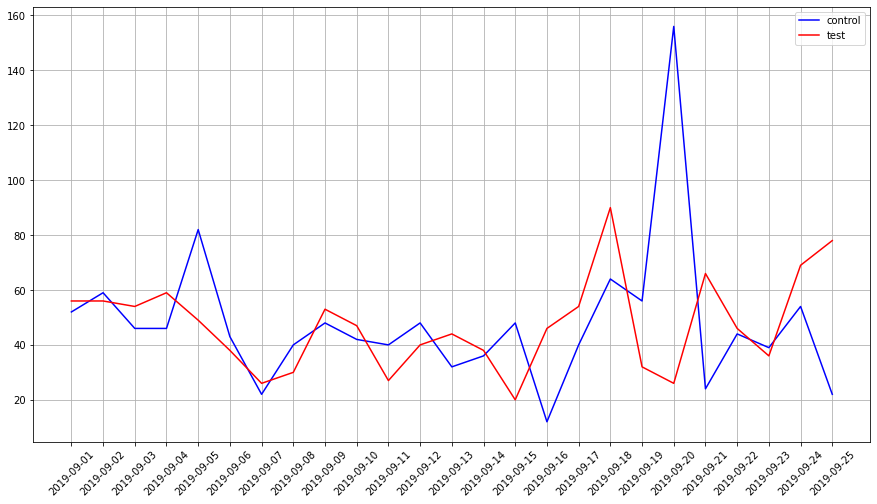

In [112]:
### Проверка датасета на выбросы

plt.figure(figsize=(15,8))
plt.plot(control.date, control['cnt(addToCart)'], c = "b", label = "control")
plt.plot(test.date, test['cnt(addToCart)'], c = "r", label = "test")
plt.xticks(test.date, rotation = 45)
plt.grid()
plt.legend()
plt.show()

Анализ выбросов по количеству заказов за каждый день показывает аномально высокое число заказов в контрольной группе 20.09

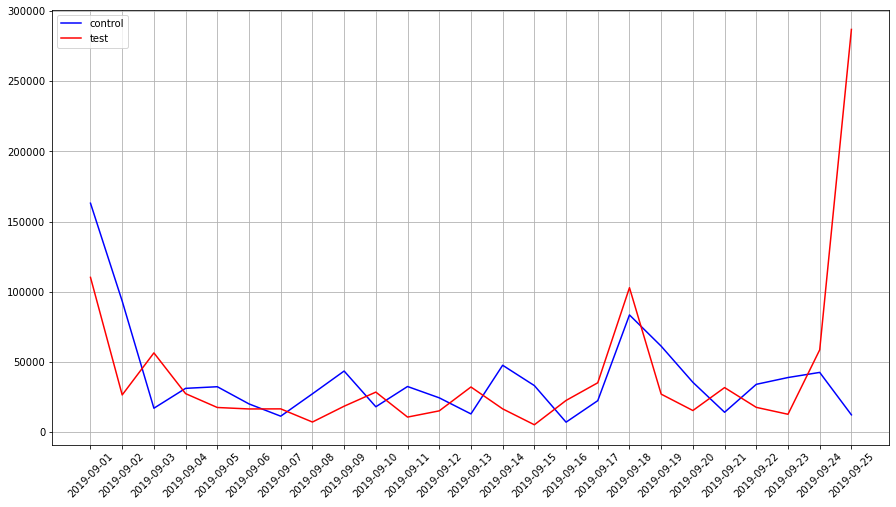

In [113]:
plt.figure(figsize=(15,8))
plt.plot(control.date, control["sum(addToCartItems)"], c = "b", label = "control")
plt.plot(test.date, test['sum(addToCartItems)'], c = "r", label = "test")
plt.xticks(test.date, rotation = 45)
plt.grid()
plt.legend()
plt.show()

Анализ выбросов по сумме заказов за каждый день показывает аномально высокую сумму заказов в тестовой группе 25.09

Из полученных графиков видно, что их поведение в один и тот-же день примерно схоже, за исключением двух обнаруженных аномальных значений. Из предоставленных нам данных, мы не можем ответить на вопрос, с чем они связаны. Поэтому наилучшим вариантом для проведения А-В теста в данном случае будет исключить их.

In [116]:
control = control.drop(index=19)
test = test.drop(index=19)
control = control.drop(index=24)
test = test.drop(index=24)


In [117]:
### Повторная проверка общей суммы и количества товаров за все время

c = control['sum(addToCartItems)'].sum()
t = test['sum(addToCartItems)'].sum()
perc = t/c

print(f"control:{c}, test:{t}, change:{perc}%")

control:911098, test:712753, change:0.7823011355529262%


In [118]:
c = control['cnt(addToCart)'].sum()
t = test['cnt(addToCart)'].sum()
perc = t/c

print(f"control:{c}, test:{t}, change:{perc}%")

control:1017, test:1076, change:1.0580137659783677%


После исключения аномальных значений картина резко поменялась. Теперь общая сумма добавленных в корзину позиций в контрольной группе на 21% меньше, чем в тестовой. Количество позиций за все время увеличилось в тестовой на 6% относительно контрольной.

In [119]:
### Добавим столбец со средней ценой товара за день

control["Mean"] = control['sum(addToCartItems)'] / control['cnt(addToCart)']
test["Mean"] = test['sum(addToCartItems)'] / test['cnt(addToCart)']

In [121]:
control.reset_index(inplace=True)
test.reset_index(inplace=True)

In [124]:
### Z-test 

from statsmodels.stats.proportion import proportions_ztest
new_ar=[]
for i in range(len(control)):
    count = np.array([control['cnt(addToCart)'][i], test['cnt(addToCart)'][i]])
    nobs = np.array([control['sum(addToCartItems)'][i], test['sum(addToCartItems)'][i]])
    stat, pval = proportions_ztest(count, nobs)
    new_ar.append(pval)
    

In [127]:
p_value = pd.DataFrame(new_ar)
p_value = p_value.rename(columns={0: "p_val"})
p_value['date'] =  control.date
p_value = p_value.set_index('date')


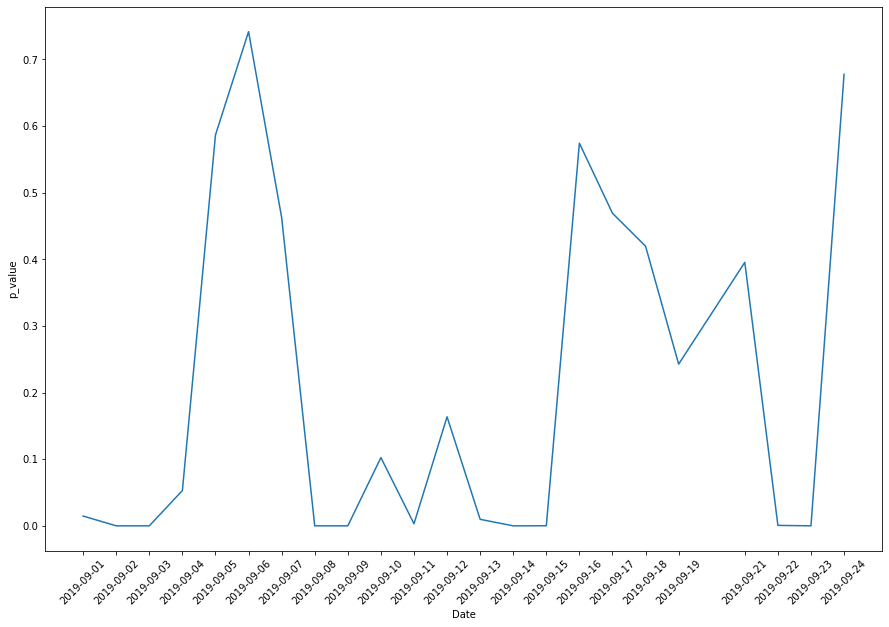

In [128]:
plt.figure(figsize=(15,10))
plt.plot(p_value.index, p_value.p_val)
plt.xlabel("Date")
plt.ylabel("p_value")
plt.xticks(p_value.index, rotation = 45)
plt.show()

Исходя из графика p_value мы можем предположить, что скорее всего новая модель работает хуже, чем старая

In [131]:
### Введем функцию bootstrap

def bootstrap(arr,n=100,N_TRIAL = 1000,func = np.mean):
    res = []
    n = min(len(arr),n)
    # Инициализируем цикл попыток
    for _ in range(N_TRIAL):
        # Делаем подвыборку размера n
        if len(arr.shape)>1:
            ind = np.random.choice(np.arange(arr.shape[0]), size = (n,))
            subsample = arr.iloc[ind]
        else:
            subsample = np.random.choice(arr, size = (n,))
        # рассчитываем статистику
        stat = func(subsample)
        res.append(stat)
    return res # shape (N_TRIAL,)

In [132]:
### Проверка значимости различий для товаров в корзине

samples_control = bootstrap(control['cnt(addToCart)'],N_TRIAL = 3000)
samples_test = bootstrap(test['cnt(addToCart)'],N_TRIAL = 3000)

/Users/vadimchibisov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/vadimchibisov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


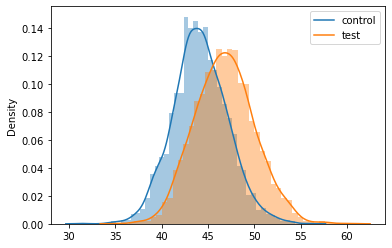

In [133]:
import seaborn as sns
ax = sns.distplot(samples_control,label = 'control')
sns.distplot(samples_test, ax = ax, label = 'test')
ax.legend(['control','test'])
plt.show()


In [134]:
buf = []
for i in range(1000):
    control_sample =  control['cnt(addToCart)'].sample(20)
    test_sample =  test['cnt(addToCart)'].sample(20)
    buf.append(np.mean(test_sample)-np.mean(control_sample))

min = -1.0512500000000042 max = 6.001249999999999


/Users/vadimchibisov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


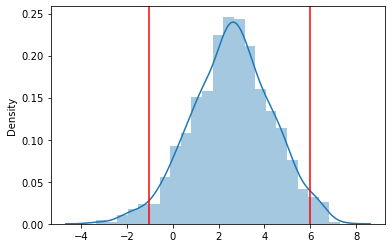

In [135]:
ax_buf = sns.distplot(buf)
ax_buf.axvline(np.percentile(buf,2.5),linestyle = '-',color='r')
ax_buf.axvline(np.percentile(buf,97.5),linestyle = '-',color='r')
print('min =',np.percentile(buf,2.5),'max =',np.percentile(buf,97.5))

Исходя из распределения средних, которое включает в себя ноль, с точки зрения разницы между группами по количеству добавления товаров в корзину отсутствует.

/Users/vadimchibisov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/vadimchibisov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


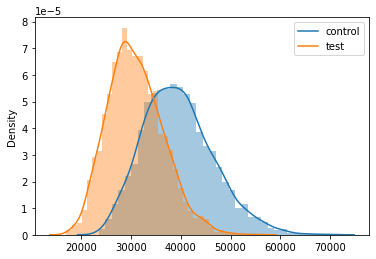

In [136]:
### Проверка значимости различий для цены товаров

samples_control = bootstrap(control['sum(addToCartItems)'],N_TRIAL = 3000)
samples_test = bootstrap(test['sum(addToCartItems)'],N_TRIAL = 3000)

ax = sns.distplot(samples_control,label = 'control')
sns.distplot(samples_test, ax = ax, label = 'test')
ax.legend(['control','test'])
plt.show()

min = -14943.766249999999 max = -657.3362500000012


/Users/vadimchibisov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


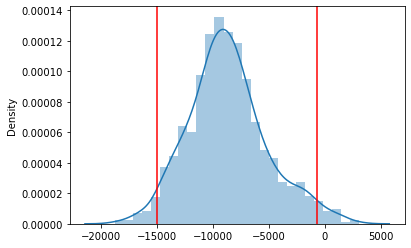

In [137]:
buf = []
for i in range(1000):
    control_sample =  control['sum(addToCartItems)'].sample(20)
    test_sample =  test['sum(addToCartItems)'].sample(20)
    buf.append(np.mean(test_sample)-np.mean(control_sample))
    
ax_buf = sns.distplot(buf)
ax_buf.axvline(np.percentile(buf,2.5),linestyle = '-',color='r')
ax_buf.axvline(np.percentile(buf,97.5),linestyle = '-',color='r')
print('min =',np.percentile(buf,2.5),'max =',np.percentile(buf,97.5))

/Users/vadimchibisov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/vadimchibisov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


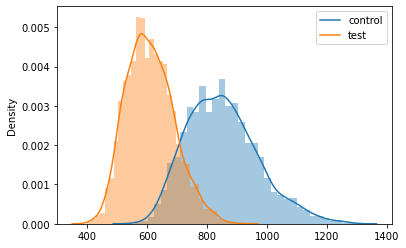

In [138]:
### Проверка значимости различий для средней цены товаров

samples_control = bootstrap(control['Mean'],N_TRIAL = 3000)
samples_test = bootstrap(test['Mean'],N_TRIAL = 3000)

ax = sns.distplot(samples_control,label = 'control')
sns.distplot(samples_test, ax = ax, label = 'test')
ax.legend(['control','test'])
plt.show()

min = -350.451484395924 max = -107.52783154663612


/Users/vadimchibisov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


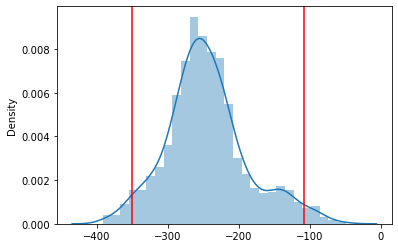

In [139]:
buf = []
for i in range(1000):
    control_sample =  control['Mean'].sample(20)
    test_sample =  test['Mean'].sample(20)
    buf.append(np.mean(test_sample)-np.mean(control_sample))
    
ax_buf = sns.distplot(buf)
ax_buf.axvline(np.percentile(buf,2.5),linestyle = '-',color='r')
ax_buf.axvline(np.percentile(buf,97.5),linestyle = '-',color='r')
print('min =',np.percentile(buf,2.5),'max =',np.percentile(buf,97.5))

### Вывод по проведенному АБ - тесту

Проведенный бутстреп анализ показал, что доверительные интервалы для общей суммы и средней цены для тестовой группы лежат левее контрольной. Для средней цены они практически не пересекаются. Ноль не входит в доверительный интервал при разности средних. Таким образом доказано, что Б вариант влияет на нашу гипотезу; в тестовом варианте сумма заказов и средняя цена товаров ниже; контрольный вариант лучше.

Для дальнейшего исследования стоит рассмотреть возможность проверки происхождения двух выбросов в первоначальном датасете. Если они таковыми не являются и статистически значимы, пересмотреть результаты данного АБ - теста.  